<a href="https://colab.research.google.com/github/JulioCesarMS/Finance/blob/main/Portfolio_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisis**

In [65]:
install.packages('Sim.DiffProc')
install.packages('abind')
install.packages('pracma')
install.packages('ggrepel')
install.packages('readr')
install.packages('use_course_details')
#devtools::install_github("delabj/ggCyberPunk")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [69]:
library('ggplot2')
library('dplyr')
library('tidyr')
library('Sim.DiffProc')
library('abind')
library('pracma')
library('ggrepel')
library('readr')
library('usethis')
#library('ggCyberPunk')
options(warn=-1)

In [55]:
getReturns<-function(x, simple=TRUE){
  names<-c(names(x)[-1])
  time<-x[-1,1]
  x<-as.matrix(x[,-1],ncol=ncol(x[,-1]),byrow=FALSE) 
  B<- matrix(ncol=ncol(x),nrow=nrow(x)-1)
  for(i in 1:ncol(x)){
    if(simple){
      B[,i] <- (exp(diff(log(x[,i]),lag=1)) - 1)
    }else{
      B[,i]<-diff(log(x[,i]),lag=1)
    }
        
  }
  B<-data.frame(B)     
  colnames(B)<-names
  C<-data.frame(Date=time,B)
  return(C)
}

In [82]:
# download from github
download.file(url ='https://github.com/JulioCesarMS/Finance-Readme.md/blob/main/datasets/base_full.zip', destfile = "base_full.zip")
unzip(zipfile = "base_full.zip")

base <- read.csv(list.files()[1]) %>% mutate('Date'=as.Date(Date, format="%Y-%m-%d"))
head(base)

,Date,Stock,Price,Index
,<date>,<chr>,<dbl>,<chr>
1,2000-01-03,WMT,66.812500,down
2,2000-01-03,MRK,64.527672,down
3,2000-01-03,INTC,43.500000,down
4,2000-01-03,MSFT,58.281250,down
5,2000-01-03,MMM,47.187500,down
6,2000-01-03,AAPL,0.999442,down


In [6]:
indices <- unique(base$Index)
base_ret <- base %>% 
  filter(Index==indices[1]) %>% 
  pivot_wider(names_from='Stock', values_from='Price') %>% 
  select(-Index) %>% 
  getReturns() %>% 
  pivot_longer(!Date, names_to='Stock', values_to='Returns') %>% 
  mutate('Index'= indices[1])

for(i in 2:length(indices)){
  base_i <- base %>% 
    filter(Index==indices[i]) %>% 
    pivot_wider(names_from='Stock', values_from='Price')  %>% 
    select(-Index) %>% 
    getReturns() %>% 
    pivot_longer(!Date, names_to='Stock', values_to='Returns') %>% 
    mutate('Index'= indices[i])
  base_ret <- rbind(base_ret, base_i)
}

In [7]:
head(base_ret)

Date,Stock,Returns,Index
<date>,<chr>,<dbl>,<chr>
2000-01-04,WMT,-0.03741815,down
2000-01-04,MRK,-0.03512013,down
2000-01-04,INTC,-0.04669540,down
2000-01-04,MSFT,-0.03378016,down
2000-01-04,MMM,-0.03973510,down
2000-01-04,AAPL,-0.08431001,down


In [14]:
length(base_ret%>%filter(Index=='down', Stock=='WMT')%>%select(Returns)%>%pull())

[1] 5283

## **Distribución de los rendimientos**

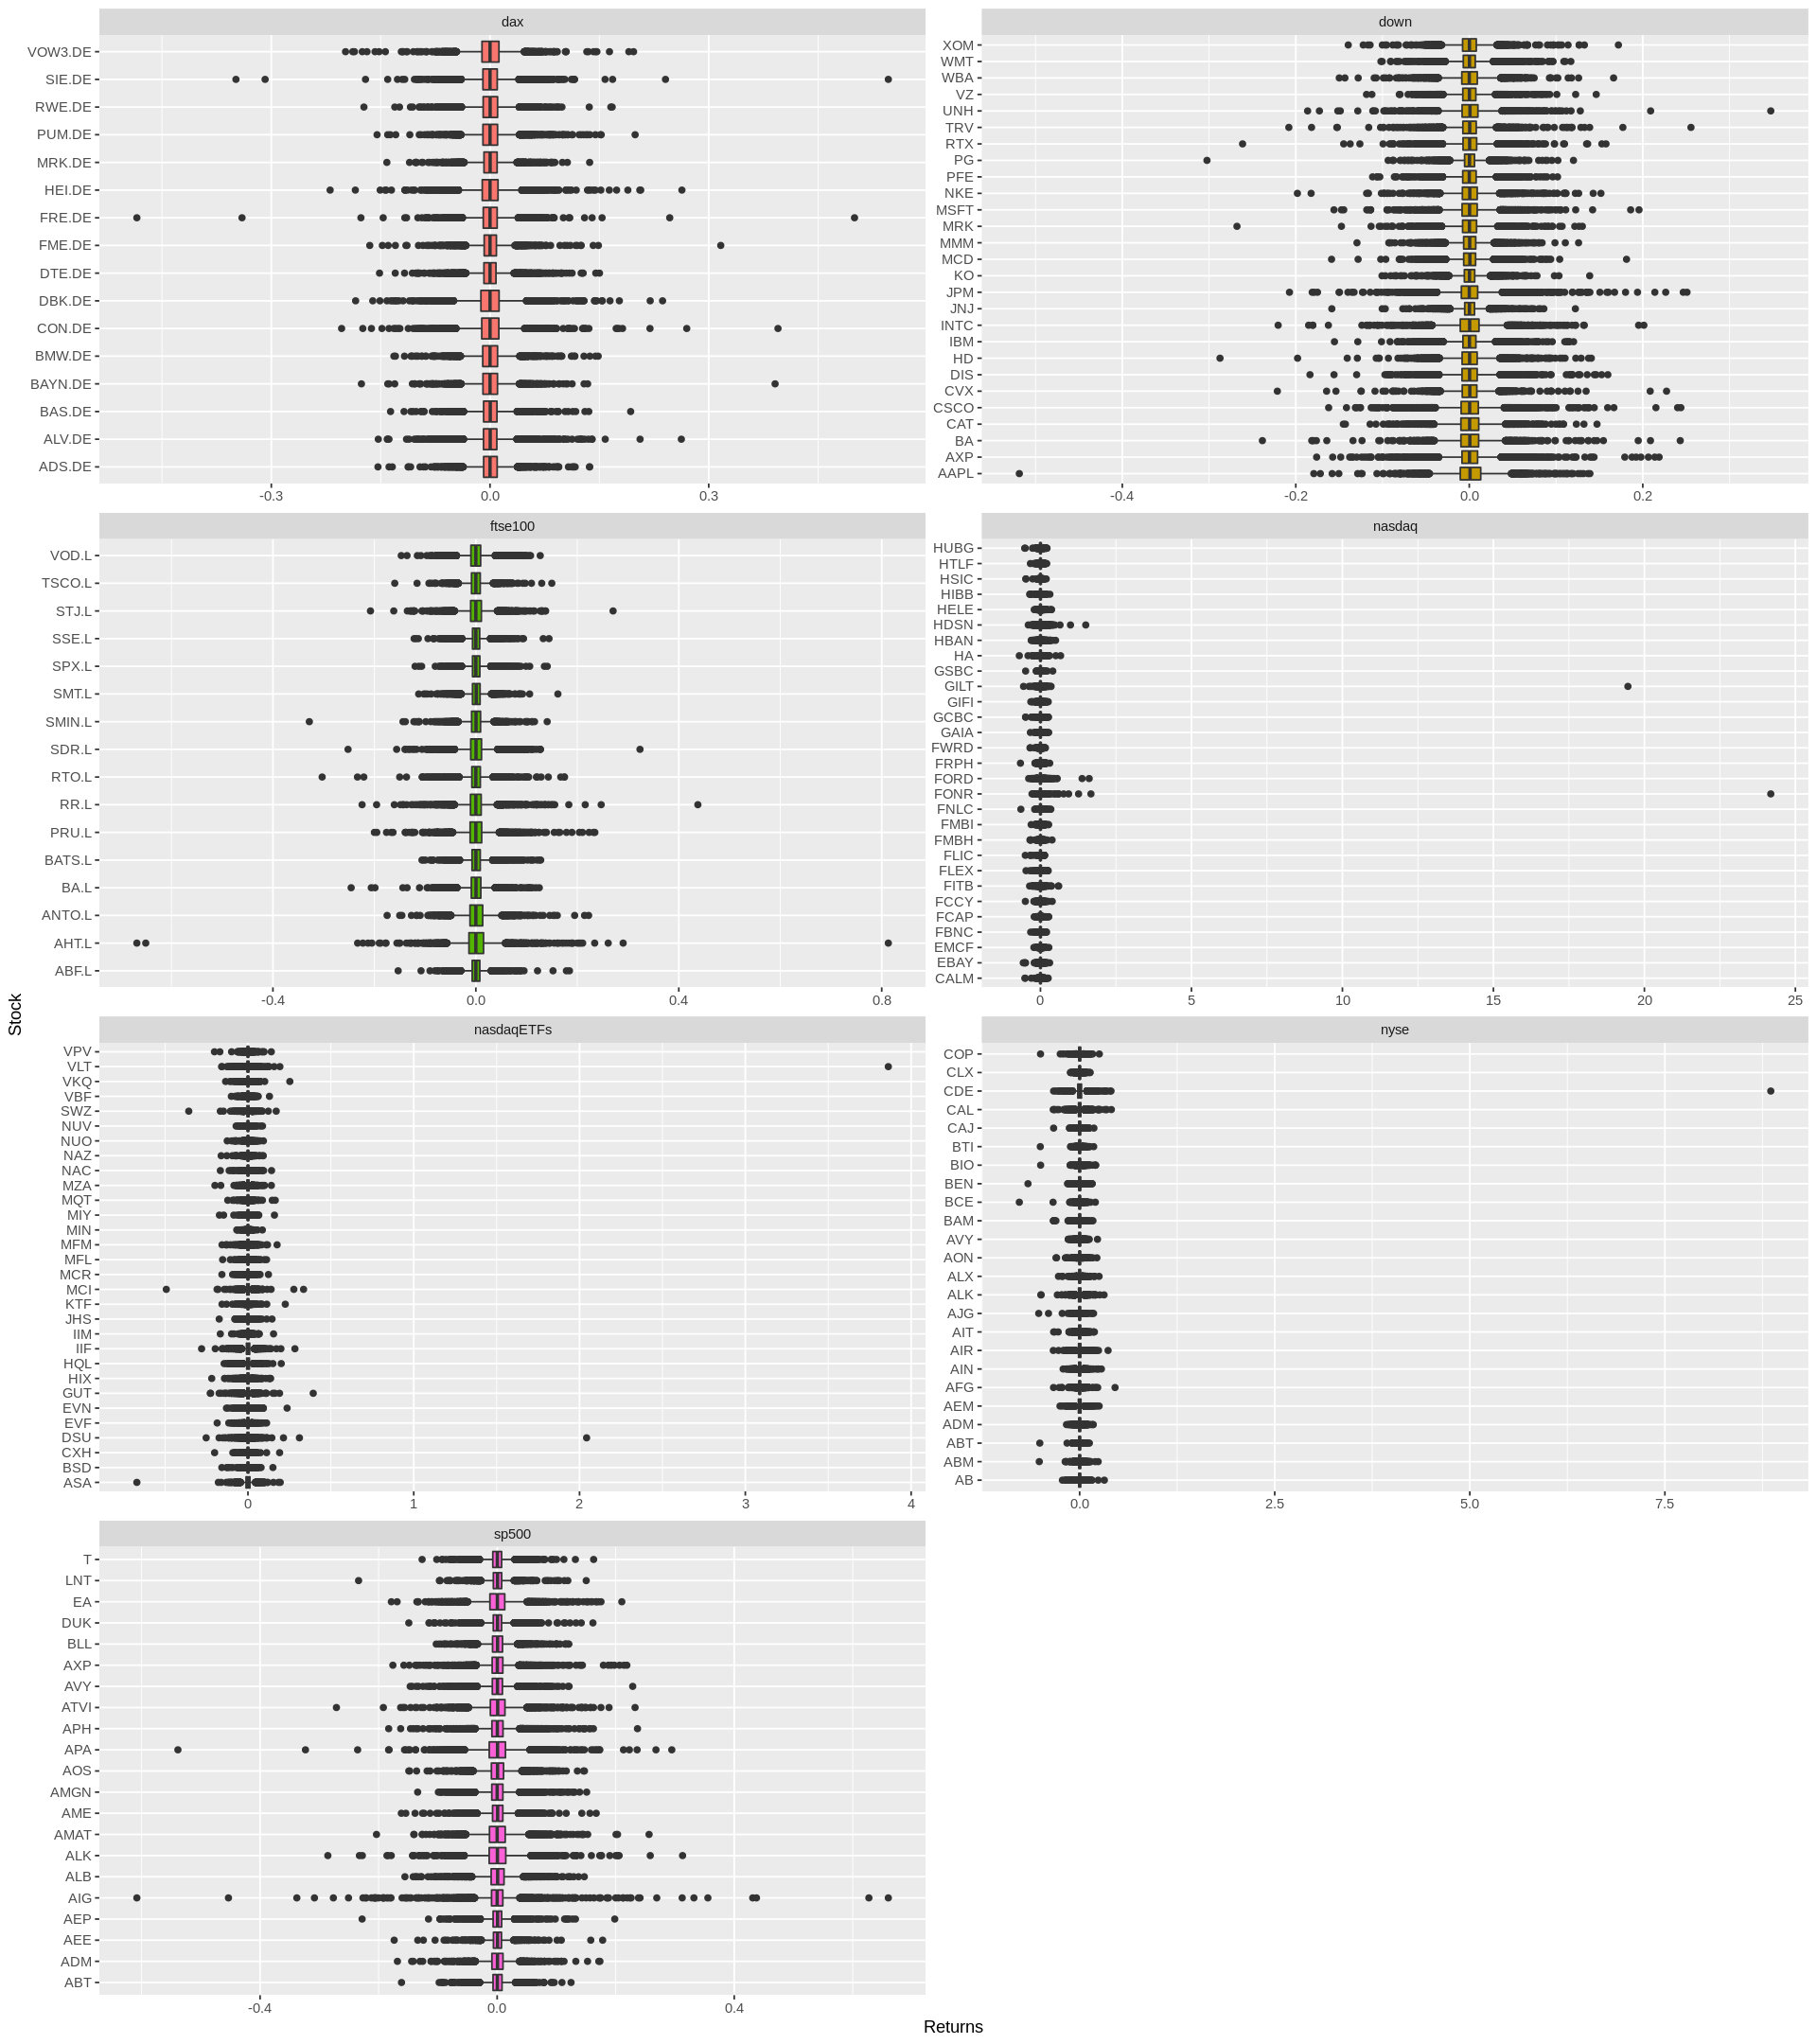

In [35]:
options(repr.plot.width=16, repr.plot.height=18)
p2 <- ggplot(base_ret, aes(x=Stock, y=Returns, fill=Index) ) +
  geom_boxplot() +
  coord_flip()+ 
  facet_wrap(vars(Index), ncol=2, scale="free") +
  theme(legend.position = "None")

p2

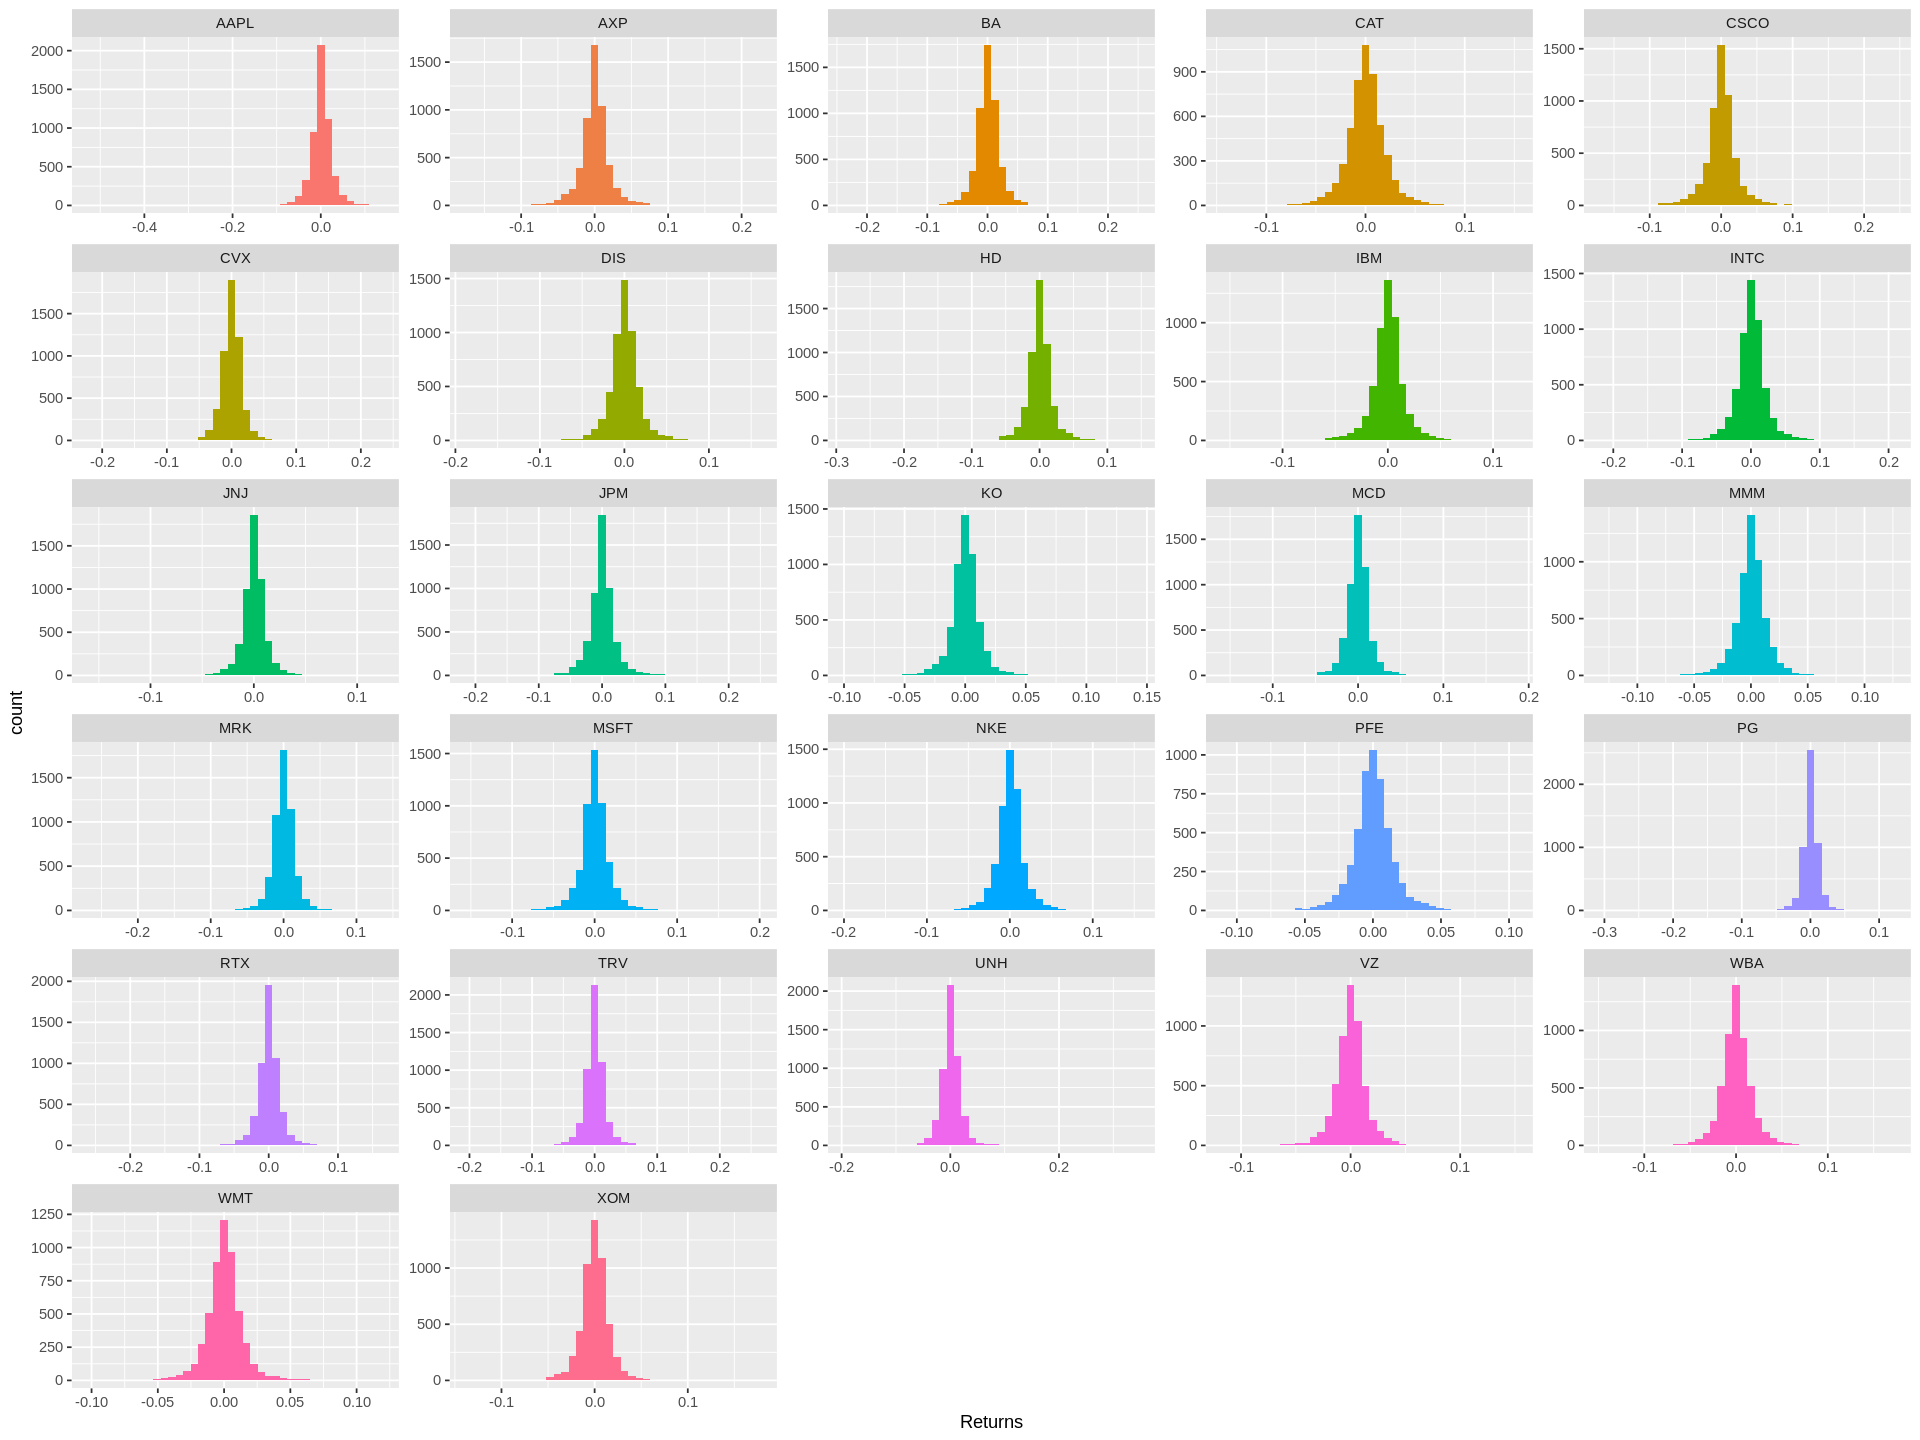

In [8]:
options(repr.plot.width=16, repr.plot.height=12)
p2 <- ggplot(base_ret%>%filter(Index=='down'), aes(x=Returns, fill=Stock) ) +
  geom_histogram(bins = 40) +
  facet_wrap(vars(Stock), ncol=5, scale="free") +
  theme(legend.position = "None")

p2

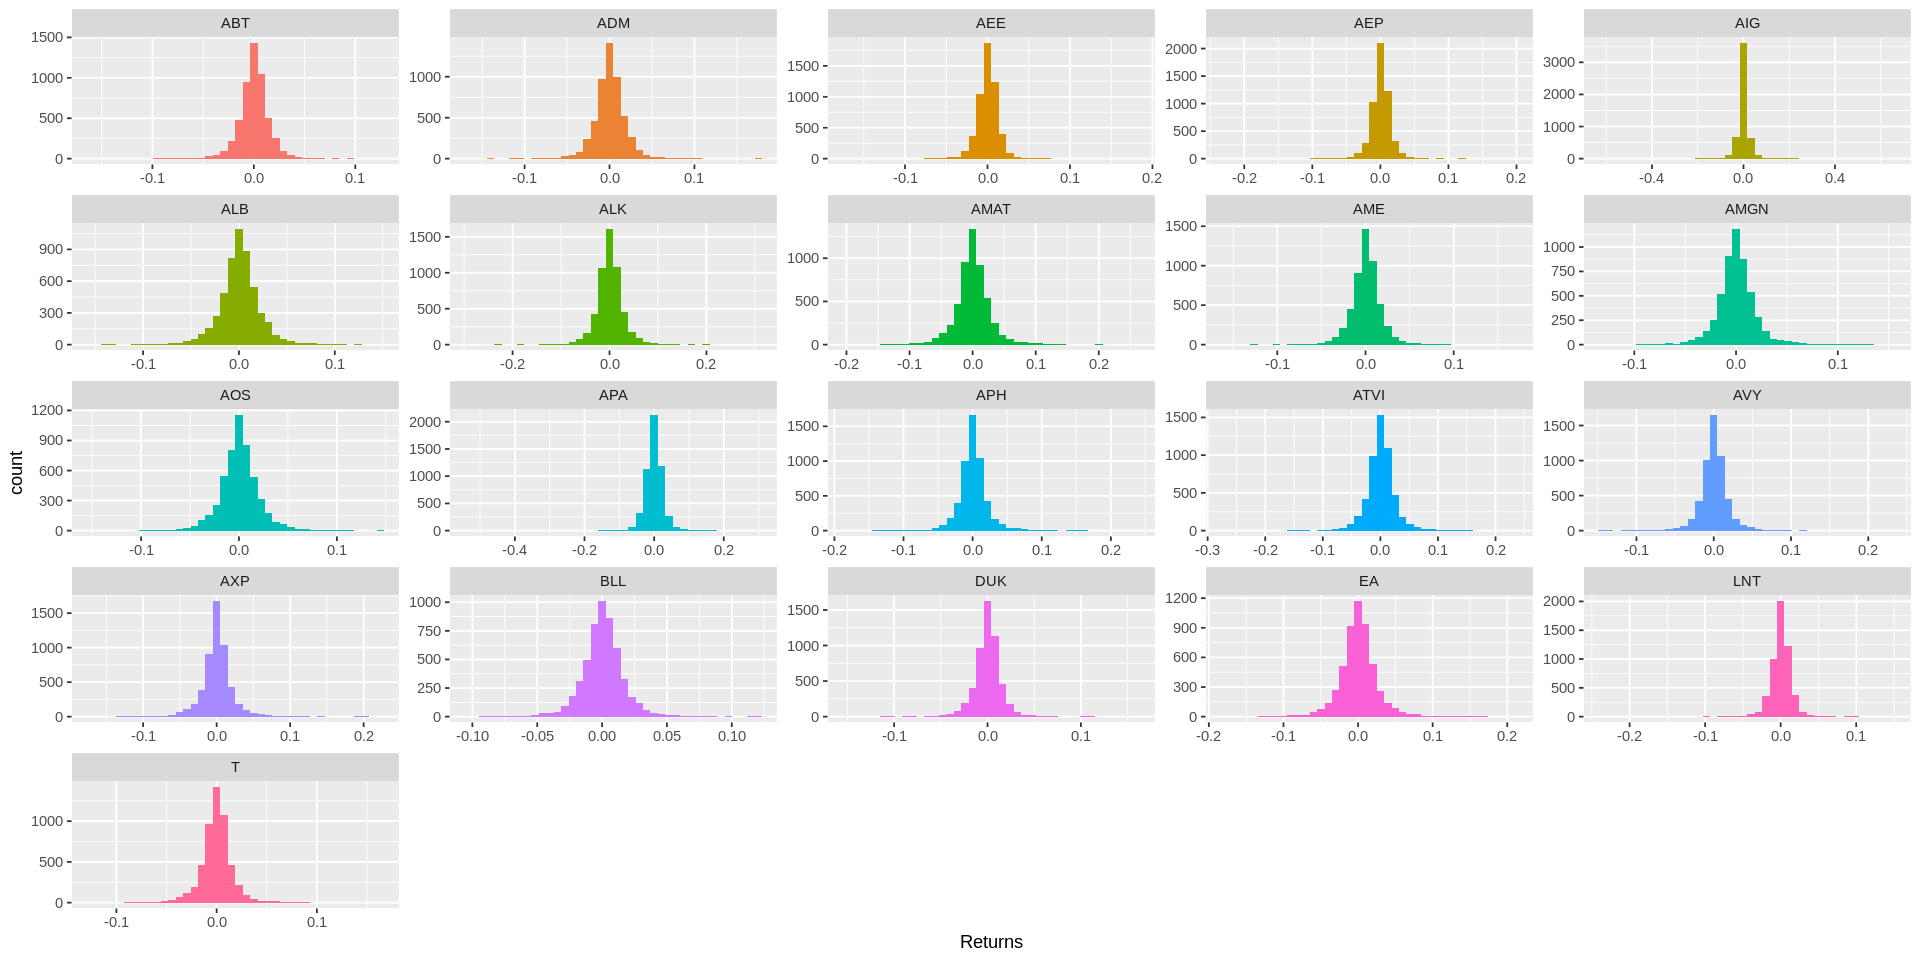

In [24]:
options(repr.plot.width=16, repr.plot.height=8)
p2 <- ggplot(base_ret%>%filter(Index=='sp500'), aes(x=Returns, fill=Stock) ) +
  geom_histogram(bins = 40) +
  facet_wrap(vars(Stock), ncol=5, scale="free") +
  theme(legend.position = "None")

p2

In [38]:
ks.test(base_ret%>%filter(Index=='down', Stock=='WMT')%>%select(Returns)%>%pull(), 'pnorm')$statistic

Warning message in ks.test.default(base_ret %>% filter(Index == "down", Stock == :
“ties should not be present for the Kolmogorov-Smirnov test”


D 
0.4751657

## **Normalidad**

Kolmogorov-Smirnov test:

$H_0$ :	The data follow a specified distribution

$H_a$ :	The data do not follow the specified distribution

In [10]:
norm.test <- base_ret %>% 
  group_by(Stock, Index) %>% 
  summarise(ret = list(Returns)) %>% 
  mutate(statistic = ks.test(unlist(ret), 'pnorm')$statistic,
         p_value = ks.test(unlist(ret), 'pnorm')$p.value) %>%
  ungroup() %>% 
  data.frame() %>% 
  select(-ret) %>%
  arrange((Index))


`summarise()` has grouped output by 'Stock'. You can override using the
`.groups` argument.


In [27]:
norm.test%>%filter(Index=='down')

Stock,Index,statistic,p_value
<chr>,<chr>,<dbl>,<dbl>
AAPL,down,0.4649191,0
AXP,down,0.4646905,0
BA,down,0.4681521,0
CAT,down,0.4687237,0
CSCO,down,0.4621801,0
CVX,down,0.4747917,0
DIS,down,0.4701448,0
HD,down,0.4714074,0
IBM,down,0.4723251,0


In [15]:
cor.md <- function(base){
  # input:
  #   base : returns with date as first column
  # output:
  #   array 3-dimensional (1-2d correlation, 3d time)
  for(i in 2:nrow(base)){
    if(i == 2){
      arr <- cor(base[1:i,-1])
    } else{
      df <- cor(base[1:i,-1])
      arr <- abind(arr, df, along=3)
    }
  }
  dimnames(arr)[[3]] <- as.vector(as.character(base$Date[-1]))
  
  return(arr)
}

In [37]:
ind <- base_ret%>%filter(Index=='sp500')%>%pivot_wider(names_from='Stock', values_from='Returns')%>%select(-Index)
head(down)

Date,WMT,MRK,INTC,MSFT,MMM,AAPL,VZ,JNJ,KO,⋯,NKE,DIS,HD,TRV,RTX,AXP,CVX,JPM,XOM,BA
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2000-01-04,-0.03741815,-0.035120128,-0.046695402,-0.033780161,-0.03973510,-0.08431001,-0.032325296,-0.036610169,0.001108647,⋯,-0.054545455,0.05857743,-0.05273250,-0.013257576,-0.040999964,-0.037758267,0.000000000,-0.027444228,-0.019154030,-0.00155521
2000-01-05,-0.02040816,0.039271962,0.008289375,0.010543840,0.02896552,0.01463317,0.033405126,0.010555947,0.008859358,⋯,0.057692308,0.04150196,0.02024291,-0.007677543,-0.019812319,-0.026848423,0.017937220,-0.006172866,0.054515867,0.06230530
2000-01-06,0.01091270,0.008295032,-0.058295964,-0.033498078,0.08042895,-0.08653837,-0.011470243,0.031337047,0.001097695,⋯,-0.005194805,-0.03984818,-0.04761905,0.019342360,0.047872348,0.020373457,0.042584435,0.014197011,0.051697531,0.01026393
2000-01-07,0.07556428,0.095978015,0.041269841,0.013068182,0.01985112,0.04736896,-0.007384000,0.042538825,0.065789474,⋯,0.000000000,-0.01581027,0.05833333,0.039848197,0.039593948,0.014559097,0.017605634,0.018372703,-0.002934703,0.02902758
2000-01-10,-0.01824818,-0.029191015,0.045731707,0.007291082,-0.00486618,-0.01758794,-0.005313459,-0.025259067,-0.031893004,⋯,0.016971359,0.15261050,-0.00492126,-0.018248175,0.009765542,0.013940108,-0.026989619,-0.017182104,-0.013980868,-0.01410437
2000-01-11,-0.01486989,0.003436407,0.045918367,-0.025612472,-0.01711491,-0.05115103,-0.009348297,0.003322259,0.034006376,⋯,0.050064103,0.01045286,-0.02571711,-0.011152416,-0.023210805,0.009300444,-0.009246088,-0.023601398,0.002985075,-0.01859800


In [38]:
matcor <- cor.md(ind)

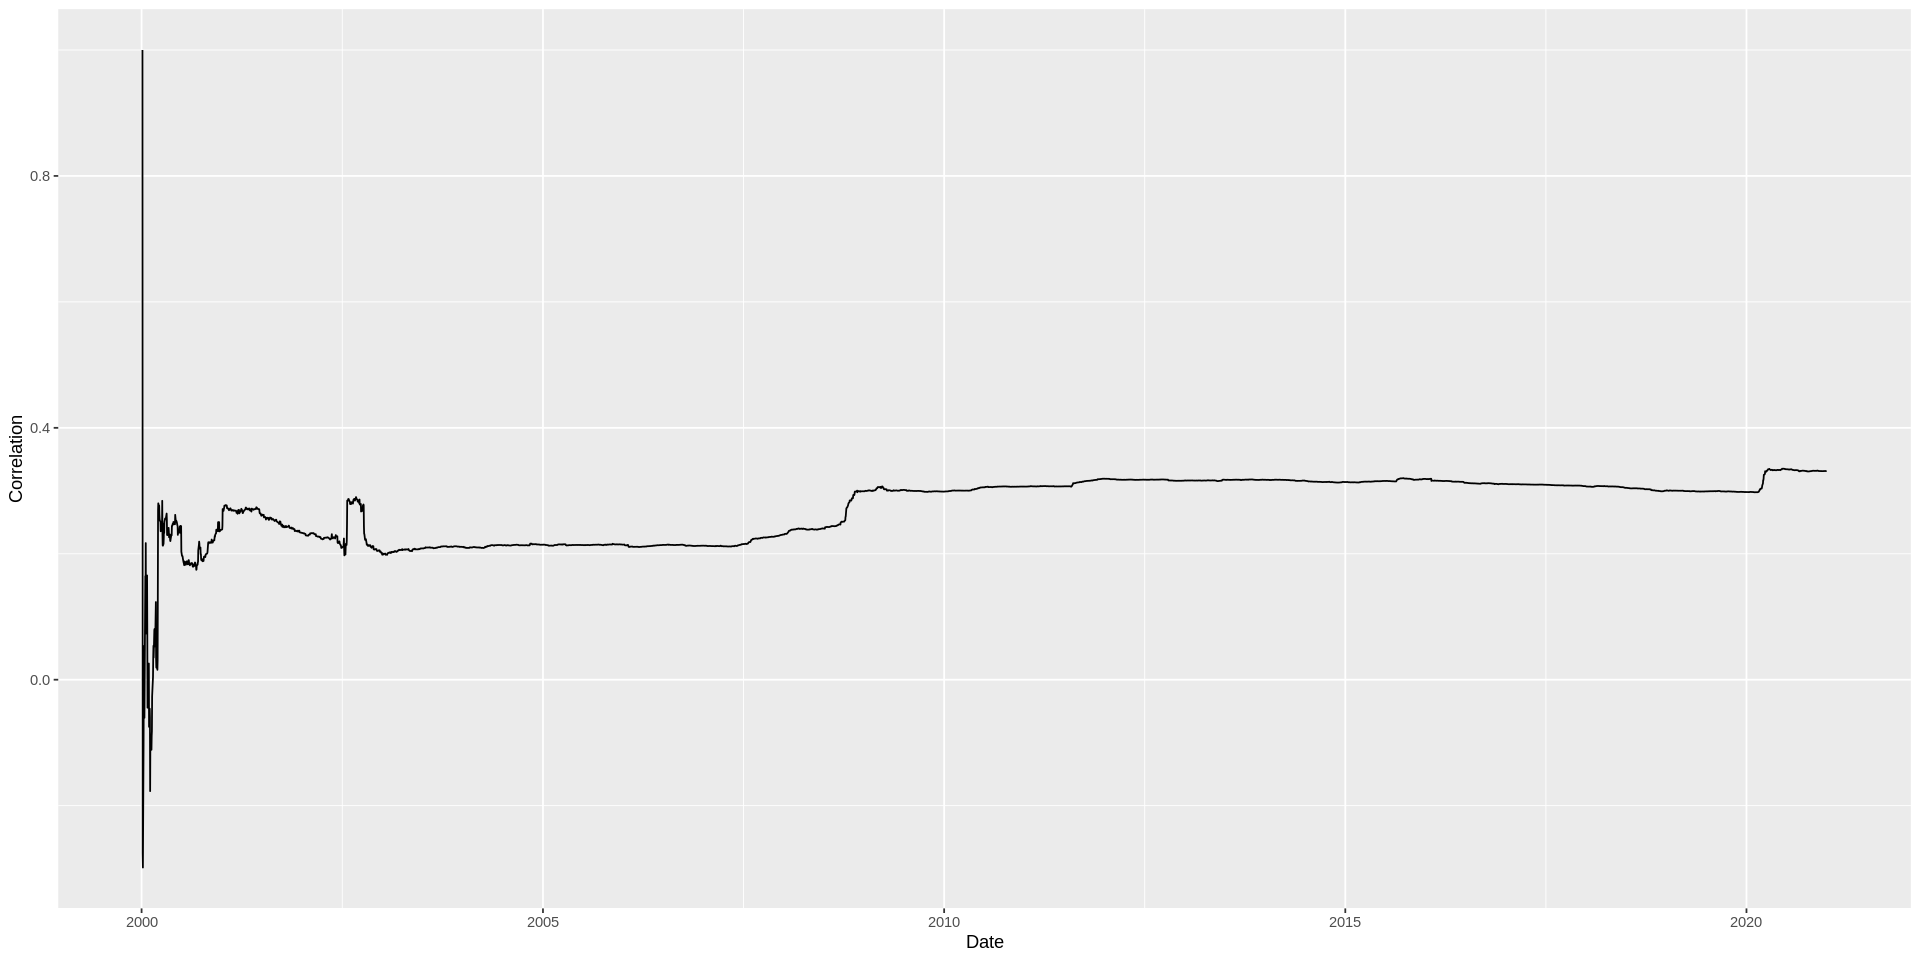

In [41]:
# df
df01 <- data.frame(matcor[1,7,]) %>%mutate('Date'=as.Date(row.names(.)))
colnames(df01) <- c('Correlation', 'Date')
# Gráfico
options(repr.plot.width=16, repr.plot.height=8)
p1 <- ggplot(df01, aes(x=Date, y=Correlation)) +
  geom_line()
p1

# **Hurst exponent**


Interpretación:

- $H < 0.5$ : Si el valor de Hurst es inferior a 0,5, se puede considerar una serie temporal antipersistente
- $H = 0.5$ : Si el valor de Hurst es 0,5, indicaría que se trata de un paseo aleatorio o de un mercado en el que no es posible predecir el futuro basándose en los datos del pasado.
- $H > 0.5$ : Si el valor de Hurst es superior a 0,5, indicaría una serie temporal persistente (se traduce en un mercado con tendencia)

In [51]:
hurstexp(base_ret%>%filter(Index=='down', Stock=='WMT')%>%select(Returns)%>%pull())$He

Simple R/S Hurst estimation:         0.4615608 
Corrected R over S Hurst exponent:   0.465389 
Empirical Hurst exponent:            0.4432629 
Corrected empirical Hurst exponent:  0.4157424 
Theoretical Hurst exponent:          0.5287201 


[1] 0.4432629

In [19]:
husrt.exp <- base_ret %>% 
  group_by(Stock, Index) %>% 
  summarise(ret = list(Returns)) %>% 
  mutate('husrtexp' = round(hurstexp(unlist(ret))$He,2)) %>%
  ungroup() %>% 
  data.frame() %>% 
  select(-ret) %>%
  arrange((Index)) %>%
  select(Index, Stock, husrtexp)

`summarise()` has grouped output by 'Stock'. You can override using the
`.groups` argument.


Simple R/S Hurst estimation:         0.5277079 
Corrected R over S Hurst exponent:   0.5591837 
Empirical Hurst exponent:            0.5587543 
Corrected empirical Hurst exponent:  0.5288796 
Theoretical Hurst exponent:          0.5287201 
Simple R/S Hurst estimation:         0.512232 
Corrected R over S Hurst exponent:   0.531826 
Empirical Hurst exponent:            0.5466781 
Corrected empirical Hurst exponent:  0.5171804 
Theoretical Hurst exponent:          0.5287201 
Simple R/S Hurst estimation:         0.506665 
Corrected R over S Hurst exponent:   0.5146978 
Empirical Hurst exponent:            0.4689078 
Corrected empirical Hurst exponent:  0.4415131 
Theoretical Hurst exponent:          0.5287201 
Simple R/S Hurst estimation:         0.468198 
Corrected R over S Hurst exponent:   0.4870902 
Empirical Hurst exponent:            0.4963698 
Corrected empirical Hurst exponent:  0.4656577 
Theoretical Hurst exponent:          0.5287201 
Simple R/S Hurst estimation:         0.48809

In [43]:
husrt_table <- husrt.exp %>% 
  mutate('class'=ifelse(husrtexp < 0.50, '<0.50', ifelse(husrtexp > 0.50, '>0.50', '=0.50'))) %>% 
  group_by(Index, class) %>% 
  summarize('n'=n())%>%
  pivot_wider(names_from='class', values_from='n')

husrt_table

`summarise()` has grouped output by 'Index'. You can override using the
`.groups` argument.


Index,<0.50,=0.50,>0.50
<chr>,<int>,<int>,<int>
dax,1,4,11
down,16,3,8
ftse100,7,4,5
nasdaq,11,1,17
nasdaqETFs,2,3,25
nyse,10,4,10
sp500,10,NA,11


In [21]:
base.stocks <- base_ret %>% 
    group_by(Index, Stock) %>%
    summarise(#n = n(), 
              mean = mean(Returns), 
              sd = sd(Returns),
              sr = mean / sd, 
              min = min(Returns),
              max = max(Returns),
              skeness = skewness(Returns),
              kurtosis = kurtosis(Returns)) %>%
    ungroup() %>%
    data.frame()
head(base.stocks)

`summarise()` has grouped output by 'Index'. You can override using the
`.groups` argument.


,Index,Stock,mean,sd,sr,min,max,skeness,kurtosis
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,dax,ADS.DE,0.0007096084,0.01928155,0.036802464,-0.1537037,0.1365902,0.1614439,9.551690
2,dax,ALV.DE,0.0001548282,0.02202962,0.007028183,-0.1532771,0.2624481,0.5479442,14.933056
3,dax,BAS.DE,0.0003467648,0.01855458,0.018688905,-0.1364531,0.1929230,0.3171441,10.447918
4,dax,BAYN.DE,0.0002166669,0.02057170,0.010532282,-0.1764057,0.3910506,1.1146814,32.403446
5,dax,BMW.DE,0.0003896866,0.02101854,0.018540136,-0.1318505,0.1483843,0.1827266,7.964684
6,dax,CON.DE,0.0006589390,0.02498979,0.026368329,-0.2035758,0.3950191,1.1427330,24.242438


In [22]:
base_stat <- left_join(base.stocks, husrt.exp,  by=c('Index', 'Stock')) %>% 
  mutate('class'=ifelse(husrtexp < 0.50, '<0.50', ifelse(husrtexp > 0.50, '>0.50', '=0.50')))
head(base_stat)

,Index,Stock,mean,sd,sr,min,max,skeness,kurtosis,husrtexp,class
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,dax,ADS.DE,0.0007096084,0.01928155,0.036802464,-0.1537037,0.1365902,0.1614439,9.551690,0.48,<0.50
2,dax,ALV.DE,0.0001548282,0.02202962,0.007028183,-0.1532771,0.2624481,0.5479442,14.933056,0.53,>0.50
3,dax,BAS.DE,0.0003467648,0.01855458,0.018688905,-0.1364531,0.1929230,0.3171441,10.447918,0.50,=0.50
4,dax,BAYN.DE,0.0002166669,0.02057170,0.010532282,-0.1764057,0.3910506,1.1146814,32.403446,0.53,>0.50
5,dax,BMW.DE,0.0003896866,0.02101854,0.018540136,-0.1318505,0.1483843,0.1827266,7.964684,0.52,>0.50
6,dax,CON.DE,0.0006589390,0.02498979,0.026368329,-0.2035758,0.3950191,1.1427330,24.242438,0.61,>0.50


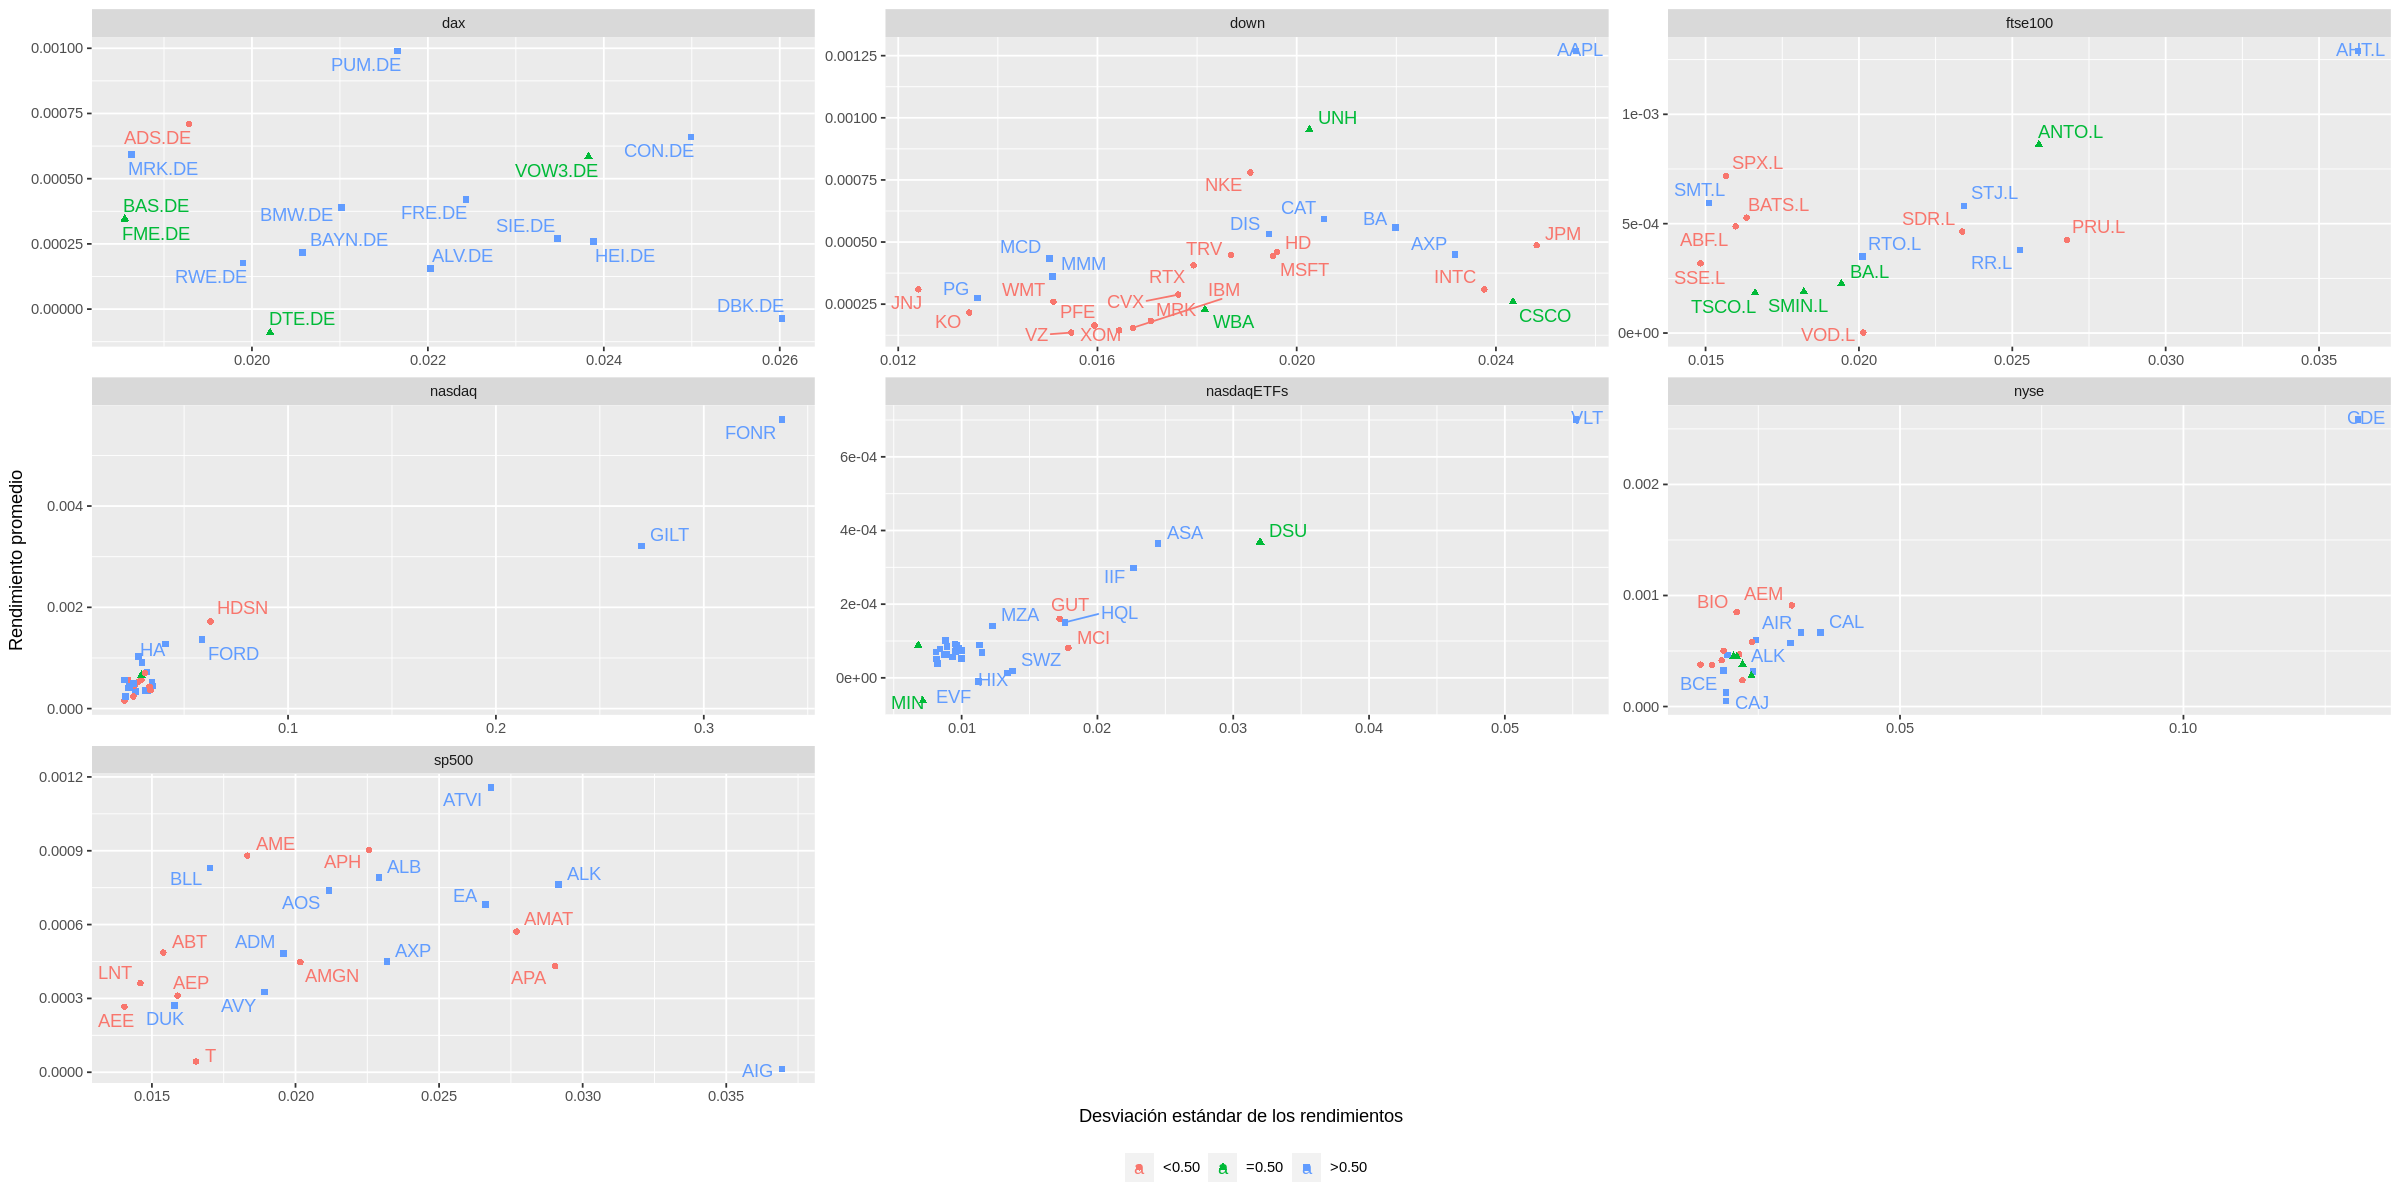

In [23]:
options(repr.plot.width=20, repr.plot.height=10)
p0 <- ggplot(base_stat, aes(x=sd, y=mean, color=class, shape=class)) +
    geom_point() +
    xlab('Desviación estándar de los rendimientos') +
    ylab('Rendimiento promedio') +
    facet_wrap(vars(Index), scale="free") +
    geom_text_repel(aes(label=Stock)) +
    #theme_light() +
    #theme_cyberpunk()+
    #scale_fill_cyberpunk("zune")+
    #scale_color_cyberpunk("zune")+
    #theme_minimal() +
    theme(#legend.position="none",
          legend.direction='horizontal',
          legend.position="bottom",
          legend.box = "horizontal",
          legend.title = element_blank())
p0